In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob
import numpy as np
import itertools
import matplotlib.cm as cm
import matplotlib.colors as mcolors
sns.set()
sns.set_context('talk')

In [2]:
def hill_deriv(l,n,K,x):
    return l*n*x**(n-1)*K**n/(K**n+x**n)**2

def bootstrap_gen(dataframe):
    return dataframe.sample(frac=1,replace=True)
def CVratio(experimentdata):
    return (experimentdata["<y>"].std(ddof=0)/experimentdata["<y>"].mean())/(experimentdata["<x>"].std(ddof=0)/experimentdata["<x>"].mean())
def xycorr(experimentdata):
    return experimentdata["<x>"].corr(experimentdata["<y>"])
def bootstrap_stderr_mean(experimentdata,f,n):
    bootstrap_fs = [f(bootstrap_gen(experimentdata)) for i in range(n)]
    return np.std(bootstrap_fs,ddof=0)/np.sqrt(len(experimentdata)),np.mean(bootstrap_fs)
def joinedbootstrap(experimentdata,n):
    rhos = []
    Cs = []
    for i in range(n):
        sample = bootstrap_gen(experimentdata)
        rhos.append(xycorr(sample))
        Cs.append(CVratio(sample))
    return np.std(Cs)/np.sqrt(len(experimentdata)),np.std(rhos)/np.sqrt(len(experimentdata))


files = glob.glob('no_fb_sims_largerange4_2023-02-02/*_simresults.tsv')
dfs = list()
for f in files:
    data = pd.read_csv(f,sep='\t')
    data['file'] = f
    dfs.append(data)

df = pd.concat(dfs, ignore_index=True)

In [3]:
folders = glob.glob('yfb*')
df = pd.DataFrame()
for i,folder in enumerate(folders):
    files = glob.glob(folder+'/*_simresults.tsv')
    for f in files:
        data = pd.read_csv(f,sep='\t')
        simsettings = pd.read_csv(f[:-14]+'settings.tsv',sep='\t')
        simsettings = simsettings.drop(['cov thres','flux thres'],axis=1)
        data = pd.concat([data,simsettings.loc[simsettings.index.repeat(len(data))].reset_index(drop=True)],axis=1)
        data["file"] = f
        data['covcheck'] = data['cov thres'].apply(lambda x: all(float(i) <= 0.05 for i in x.strip('[]').split(',')))
        data['usedparams'] =  data['usedparams'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split(',')]))
        df = pd.concat([df,data],ignore_index=True)


In [9]:
cols = ["file","C","rho","std_rho","std_C","covcheck","numsims","F_y","Fyapprox"]
pertdata = pd.DataFrame(columns=cols)
for f in df['file'].unique():
    #isolate data by parameter set
    experimentdata = df[df["file"] == f]
    #Total sims in the point
    nsims = len(experimentdata)
    #number of sims in data that didn't reach cov balance
    ncov = len(experimentdata[experimentdata["covcheck"]==False])
    #calculate quantity
    rho = xycorr(experimentdata)
    C_val = CVratio(experimentdata)
    #estimate standard error by bootstrapping
    std_Cval,std_rho = joinedbootstrap(experimentdata,250)
    F_y = experimentdata["Fy"].mean()
    meanparams = np.mean(np.stack(experimentdata['usedparams'].to_numpy()),axis=0)
    Fyapprox = hill_deriv(meanparams[0],meanparams[4],meanparams[5],experimentdata["<y>"].mean())
    
    df2 = pd.DataFrame([[f,C_val,rho,std_rho,std_Cval,ncov,nsims,F_y,Fyapprox]], columns= cols)
    pertdata = pd.concat([pertdata,df2])

All of the points, regardless if good or not

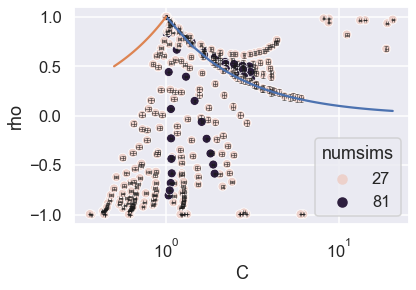

In [10]:
sns.scatterplot(data=pertdata,x="C",y="rho",hue='numsims')
plt.errorbar(y="rho", x="C", xerr="std_C", 
              yerr="std_rho", elinewidth=0.5,data=pertdata, label=None, capsize=2, capthick=0.5,color='k',fmt='none')
plt.plot(np.linspace(1,pertdata["C"].max()),1/np.linspace(1,pertdata["C"].max()))
plt.plot(np.linspace(0.5,1),np.linspace(0.5,1))
plt.xscale('log')

just points where all sims passed covcheck

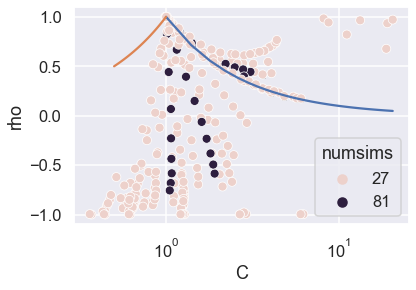

In [11]:
cleared = pertdata[pertdata["covcheck"]==0]
sns.scatterplot(data=cleared,x="C",y="rho",hue='numsims')
plt.errorbar(y="rho", x="C", xerr="std_C", 
              yerr="std_rho", elinewidth=0.5,data=cleared, label=None, capsize=2, capthick=0.5,color='k',fmt='none',zorder=-1)
plt.plot(np.linspace(1,cleared["C"].max()),1/np.linspace(1,cleared["C"].max()))
plt.plot(np.linspace(0.5,1),np.linspace(0.5,1))
plt.xscale('log')

Place to look at other slices

/var/folders/tm/37ds31ds14913tj9402vqksr0000gn/T/ipykernel_14212/3192944417.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotted["Fysign"] = np.sign(plotted["F_y"])


(0.8, 1.2)

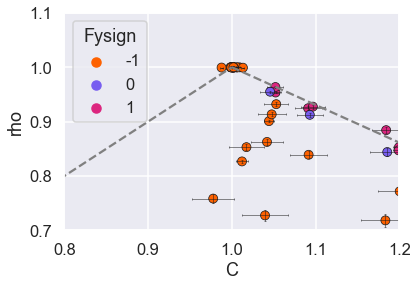

In [14]:
plotted = pertdata[pertdata['covcheck']==0]
plotted["Fysign"] = np.sign(plotted["F_y"])
sns.scatterplot(data=plotted,x="C",y="rho",hue='Fysign',alpha=1,edgecolor='k',palette=['#FE6100','#785EF0','#DC267F'])
plt.errorbar(y="rho", x="C", xerr="std_C", 
              yerr="std_rho", elinewidth=0.5,data=plotted, label=None, capsize=1, capthick=0.5,color='k',fmt='none')
plt.plot(np.linspace(1,(1.1)*plotted["C"].max()),1/np.linspace(1,(1.1)*plotted["C"].max()),'--',color='gray')
plt.plot(np.linspace(0,1),np.linspace(0,1),'--',color='gray')
plt.ylim(0.7,1.1)
plt.xlim(0.8,1.2)

/var/folders/tm/37ds31ds14913tj9402vqksr0000gn/T/ipykernel_14212/1889169544.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotted[r"$f_y$ sign"] = np.sign(plotted['F_y'])


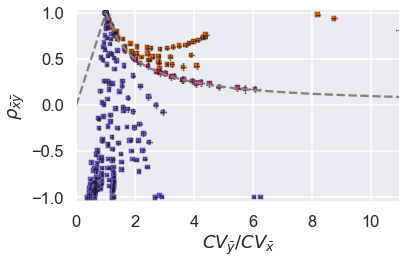

In [31]:
plotted = pertdata[(pertdata['covcheck']==0)&(pertdata['numsims']>9)]
plotted[r"$f_y$ sign"] = np.sign(plotted['F_y'])
f2,ax2 = plt.subplots()
ax2.set(xlim=(0,11),ylim=(-1.05,1.05),xlabel=r"$CV_{\bar{y}}/CV_{\bar{x}} $",ylabel=r"$\rho_{\bar{x} \bar{y}}$")
sns.scatterplot(data=plotted,x="C",y="rho",hue="$f_y$ sign",s=20,alpha=1,edgecolor='k',palette=['#785EF0','#DC267F','#FE6100'],legend=False,marker='s')
plt.errorbar(y="rho", x="C", xerr="std_C", 
              yerr="std_rho", elinewidth=0.5,data=plotted, label=None, capsize=1, capthick=0.5,color='k',fmt='none')
plt.plot(np.linspace(1,(1.1)*plotted["C"].max()),1/np.linspace(1,(1.1)*plotted["C"].max()),'--',color='gray')
plt.plot(np.linspace(0,1),np.linspace(0,1),'--',color='gray')
plt.tight_layout()
plt.savefig("nofx_fb_sims_.svg",transparent=True)

(0.0, 3.0)

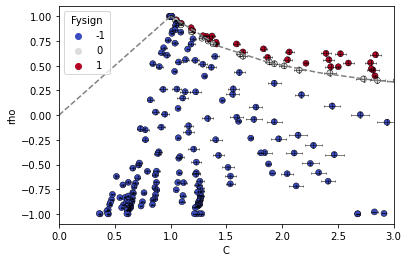

In [272]:
sns.scatterplot(data=plotted,x="C",y="rho",hue='Fysign',alpha=1,edgecolor='k',palette='coolwarm')
plt.errorbar(y="rho", x="C", xerr="std_C", 
              yerr="std_rho", elinewidth=0.5,data=plotted, label=None, capsize=1, capthick=0.5,color='k',fmt='none')
plt.plot(np.linspace(1,(1.1)*plotted["C"].max()),1/np.linspace(1,(1.1)*plotted["C"].max()),'--',color='gray')
plt.plot(np.linspace(0,1),np.linspace(0,1),'--',color='gray')
plt.xlim(0,3)

In [273]:
pertdata[(pertdata['rho']>1/pertdata['C'])&(pertdata['F_y']<0)]

,file,C,rho,std_rho,std_C,covcheck,numsims,F_y,Fyapprox
0,yfb_sims_lownoise_2023-Feb13_1723/pertset_1_pa...,1.005263,0.999763,0.000017,0.000785,1,27,-0.297209,-0.260875
0,yfb_sims_lownoise_2023-Feb13_1723/pertset_1_pa...,1.001995,0.999883,0.000005,0.000586,0,27,-0.133953,-0.125343
0,yfb_sims_lownoise_2023-Feb13_1723/pertset_1_pa...,1.005994,0.999639,0.000019,0.001195,0,27,-0.214928,-0.195255
0,yfb_sims_lownoise_2023-Feb13_1700/pertset_1_pa...,1.009194,0.999776,0.000012,0.000823,0,27,-0.051847,-0.043374
0,yfb_sims_lownoise_2023-Feb14_0940/pertset_1_pa...,1.001621,0.999967,0.0,0.000109,0,81,-0.023149,-0.02159
0,yfb_sims_lownoise_2023-Feb14_0940/pertset_1_pa...,1.001266,0.999982,0.0,0.000082,0,81,-0.01018,-0.009753
0,yfb_sims_lownoise_2023-Feb13_1801/pertset_1_pa...,1.002895,0.999878,0.000008,0.000536,0,27,-0.138423,-0.125365
0,yfb_sims_lownoise_2023-Feb13_1801/pertset_1_pa...,1.00637,0.999784,0.000012,0.001012,0,27,-0.30853,-0.253976
0,yfb_sims_highnoise_2023-Feb13_1935/pertset_1_p...,1.000361,0.999942,0.000003,0.000404,0,27,-0.037909,-0.033441
0,yfb_sims_highnoise_2023-Feb13_1935/pertset_1_p...,1.002047,0.999866,0.000008,0.000718,0,27,-0.165288,-0.148496


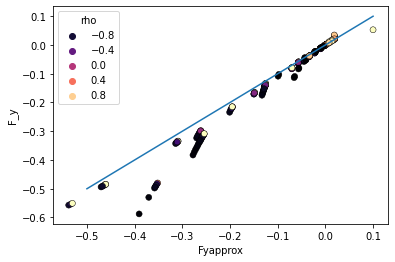

In [274]:
sns.scatterplot(data=plotted,x="Fyapprox",y="F_y",hue='rho',alpha=1,edgecolor='k',palette='magma')
plt.plot(np.linspace(-0.5,0.1),np.linspace(-0.5,0.1))

/var/folders/tm/37ds31ds14913tj9402vqksr0000gn/T/ipykernel_98082/4086373619.py:5: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t,1/t)


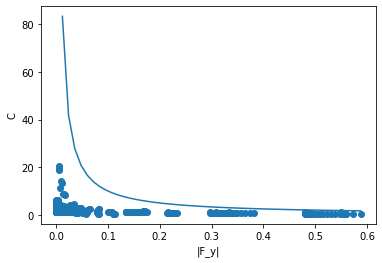

In [275]:
t = np.linspace(np.abs(pertdata['F_y']).min(),np.abs(pertdata['F_y']).max())
plt.scatter(np.abs(pertdata["F_y"]),pertdata["C"])
plt.xlabel("|F_y|")
plt.ylabel("C")
plt.plot(t,1/t)

In [6]:
df['rho_spont'] = df["cov(x,y)"]/np.sqrt(df["Var(x)"]*df["Var(y)"])
df['rhocorr'] = (df["cov(x,y)"]/np.sqrt(df["Var(x)"]*df["Var(y)"]))/(1-(df['<y>']/df["Var(y)"]))
df['C_spont'] = (np.sqrt(df["Var(y)"])/df["<y>"])/(np.sqrt(df["Var(x)"])/df["<x>"])

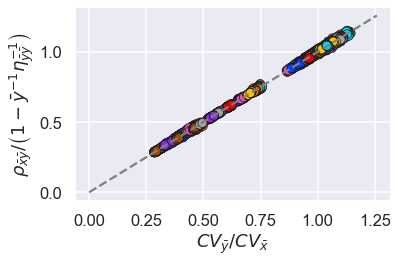

In [24]:
#bounds = 0.9*df['C_spont'].min(),1.1*df['C_spont'].max()
bounds=0,1.1*df['C_spont'].max()
t=np.linspace(bounds[0],bounds[1])
sns.scatterplot(data=df[df['covcheck']==True],x='C_spont',y='rhocorr',
                edgecolor='k',hue='file',palette='bright',legend=False)
plt.plot(t,t,'--',color='gray')
plt.ylabel(r'$\rho_{\bar{x}\bar{y}}/\left(1-\bar{y}^{-1}\eta_{\bar{y}\bar{y}}^{-1}\right)$')
plt.xlabel(r"$CV_{\bar{y}}/CV_{\bar{x}} $")
plt.tight_layout()
plt.savefig("stochrel_nofx.svg",transparent=True)